# **Import Needed Libraries**

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix, classification_report,f1_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import gensim
from gensim.models import Phrases
import wordcloud
import pickle
import json
from sklearn.manifold import TSNE

In [48]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Load saved files**

## **Load Labeled Linkedin Jobs Datasets**

In [49]:
df = pd.read_csv("/content/labeled_linkedin_jobs.csv")
df

,job_id,job_title,job_desc,experience_level,work_type,location,industry,job_posting_url,texts,texts_preprocessed,cluster_labels_lda1,cluster_labels_tfidf2
0,3757935025,Veterinarian,We are looking to hire an Associate Veterinari...,Senior,Full-time,Michigan,Healthcare,https://www.linkedin.com/jobs/view/3757935025/...,Veterinarian We are looking to hire an Associa...,veterinarian associate veterinarian doctor vet...,1,11
1,3757934327,Veterinarian,We are looking to hire an Associate Veterinari...,Senior,Full-time,Colorado,Healthcare,https://www.linkedin.com/jobs/view/3757934327/...,Veterinarian We are looking to hire an Associa...,veterinarian associate veterinarian doctor vet...,1,11
2,3757933458,Veterinarian,We are looking to hire an Associate Veterinari...,Senior,Full-time,California,Healthcare,https://www.linkedin.com/jobs/view/3757933458/...,Veterinarian We are looking to hire an Associa...,veterinarian associate veterinarian doctor vet...,1,11
3,3757932826,Veterinarian,We are looking to hire an Associate Veterinari...,Senior,Full-time,Pennsylvania,Healthcare,https://www.linkedin.com/jobs/view/3757932826/...,Veterinarian We are looking to hire an Associa...,veterinarian associate veterinarian doctor vet...,1,11
4,3757931806,Veterinarian,We are looking to hire an Associate Veterinari...,Senior,Full-time,New York,Healthcare,https://www.linkedin.com/jobs/view/3757931806/...,Veterinarian We are looking to hire an Associa...,veterinarian associate veterinarian doctor vet...,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...
2233,3685418185,Software Engineer,"Who we are:Founded in 2017, Gatik is the leade...",Senior,Full-time,California,IT,https://www.linkedin.com/jobs/view/3685418185/...,"Software Engineer Who we are:Founded in 2017, ...",software engineer arefounded gatik leader auto...,2,17
2234,3684441939,Accountant,Titus Talent Strategies has partnered with SAR...,Beginner,Full-time,Wisconsin,Finance,https://www.linkedin.com/jobs/view/3684441939/...,Accountant Titus Talent Strategies has partner...,accountant titus talent strategy partnered sar...,0,14
2235,3682818140,Developer,Carefully read the JD before applying!Job Desc...,Senior,Contract,Texas,IT,https://www.linkedin.com/jobs/view/3682818140/...,Developer Carefully read the JD before applyin...,developer carefully read jd applyingjob descri...,2,0
2236,3663878663,Accountant,Bring YOUR energy to Alliant Energy!\n\nAt All...,Beginner,Full-time,Wisconsin,Finance,https://www.linkedin.com/jobs/view/3663878663/...,Accountant Bring YOUR energy to Alliant Energy...,accountant bring energy alliant energy alliant...,0,8


We will be considering the cluster_labels_lda1 as our labels for classification as the champion model was when using K-Means++ with LDA vectorized data.

## **Quick Dataset Review**

In [50]:
df.columns

Index(['job_id', 'job_title', 'job_desc', 'experience_level', 'work_type',
       'location', 'industry', 'job_posting_url', 'texts',
       'texts_preprocessed', 'cluster_labels_lda1', 'cluster_labels_tfidf2'],
      dtype='object')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 2238 non-null   int64 
 1   job_title              2238 non-null   object
 2   job_desc               2238 non-null   object
 3   experience_level       2238 non-null   object
 4   work_type              2238 non-null   object
 5   location               2238 non-null   object
 6   industry               2238 non-null   object
 7   job_posting_url        2238 non-null   object
 8   texts                  2238 non-null   object
 9   texts_preprocessed     2238 non-null   object
 10  cluster_labels_lda1    2238 non-null   int64 
 11  cluster_labels_tfidf2  2238 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 209.9+ KB


In [52]:
print(df["texts"][0])

Veterinarian We are looking to hire an Associate Veterinarian to join our practice.

Requirements

 Doctor of Veterinary degree, or equivalent, from an accredited university  Active Veterinary State License (preferred) 

Benefits

Innovative associate health and wellbeing department (Headspace app subscriptions, Vault financial wellness tool, and access to additional mental health resources) 401k retirement savings plan with company match Health/dental/vision insurance, infertility benefits, gender affirmation services Paid parental, vacation and sick leave 

Professional Development

Continuing Education Allowance and paid Continuing Education Days Academy’s Mentorship Program – participate as a mentee or mentor in a GP or ER setting Opportunities to participate in a robust Clinical Studies program 

Additional Benefits

Up to 100% Pet Care Discount for your own pets 100% paid professional liability coverage 100% paid life insurance 100% paid short-term disability insurance Access to 

In [53]:
df["texts_preprocessed"][0]

'veterinarian associate veterinarian doctor veterinary equivalent accredited university active veterinary license innovative associate health wellbeing department headspace app subscription vault financial wellness tool access additional mental health resource retirement saving plan match healthdentalvision infertility affirmation service parental vacation development continuing education allowance continuing education academy mentorship program participate mentee mentor gp er setting participate robust clinical study program additional pet care discount pet liability coverage shortterm access network doctor specialist senior fulltime michigan healthcare'

## **Load pickle files - LDA vectorizer and dictionary (champion model)**

In [54]:
with open("/content/lda_vect.pickle", 'rb') as file:
  lda_vect = pickle.load(file)

with open("/content/dictionary.pickle", 'rb') as file:
  dictionary = pickle.load(file)

##**Quick Review of LDA Topics**

In [55]:
for idx, topic in lda_vect.print_topics():
    print("Topic {}:".format(idx))
    print(topic) # Print the words and their corresponding probabilities in the topic.
    print()

Topic 0:
0.023*"data" + 0.010*"design" + 0.009*"software" + 0.009*"development" + 0.008*"business" + 0.007*"solution" + 0.007*"technology" + 0.007*"system" + 0.006*"product" + 0.006*"project"

Topic 1:
0.020*"care" + 0.017*"patient" + 0.014*"healthcare" + 0.014*"nurse" + 0.012*"travel" + 0.010*"nursing" + 0.009*"health" + 0.009*"medical" + 0.005*"hospital" + 0.005*"rn"

Topic 2:
0.019*"tax" + 0.013*"financial" + 0.011*"accounting" + 0.009*"finance" + 0.008*"business" + 0.007*"account" + 0.006*"sale" + 0.005*"plan" + 0.005*"customer" + 0.005*"management"



As we can see, Topic 0 highly resembles the IT industry, Topic 1 highly resembles the Healthcare industry, and Topic 2 highly resembles the Finance Industry.

# **Vectorize the preprocessed text data using the pickled LDA vectorizer and add the cluster labels to it**

In [56]:
docs= list(df['texts_preprocessed'].apply(lambda x: nltk.word_tokenize(x)))

# Compute bigrams.

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [57]:
# Initialize an empty list to store the dense vectors representing topic distributions for each document.
df_lda=[]

# Iterate over each document in the tokenized document list.
for i in range(len(docs)):
  # Get the topic distribution for the ith document
  lda_vector= lda_vect[dictionary.doc2bow(docs[i])]

  # Convert the topic distribution to a dense vector
  dense_vector = gensim.matutils.sparse2full(lda_vector,lda_vect.num_topics)

  # Append the dense vector representation of the topic distribution to the data_lda list.
  df_lda.append(dense_vector)

# Convert the list of dense vectors to a pandas DataFrame.
df_lda= pd.DataFrame(df_lda)
df_lda

,0,1,2
0,0.000000,0.802033,0.197120
1,0.000000,0.801369,0.197783
2,0.000000,0.806489,0.192675
3,0.000000,0.798025,0.201128
4,0.000000,0.797583,0.201570
...,...,...,...
2233,0.999596,0.000000,0.000000
2234,0.000000,0.000000,0.999680
2235,0.999628,0.000000,0.000000
2236,0.000000,0.000000,0.999551


In [58]:
df_lda["cluster_labels_lda1"] = df["cluster_labels_lda1"]

In [59]:
df_lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   0                    2238 non-null   float32
 1   1                    2238 non-null   float32
 2   2                    2238 non-null   float32
 3   cluster_labels_lda1  2238 non-null   int64  
dtypes: float32(3), int64(1)
memory usage: 43.8 KB


# **Classification**

In [60]:
# Function to evaluate classifiers
def evaluation(actual,predicted):
  conf_mat =  confusion_matrix(actual,predicted)
  class_report = classification_report(actual,predicted)

  return conf_mat, class_report

In [61]:
# Function to calculate trainning and validation accuracies learning curves
def plot_learning_curves(model, x, y, cv=10):
    train_sizes, train_scores, test_scores = learning_curve(
        model, x, y, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
    plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## **Split data into training and testing**

In [62]:
train, test = train_test_split(df_lda, test_size = 0.2,random_state = 42)

In [63]:
train_X = train.drop(columns = ["cluster_labels_lda1"]).values
train_y = train["cluster_labels_lda1"].values
test_X = test.drop(columns = ["cluster_labels_lda1"]).values
test_y = test["cluster_labels_lda1"].values

In [64]:
train_X.shape , train_y.shape ,test_X.shape , test_y.shape

((1790, 3), (1790,), (448, 3), (448,))

## **KNN**

Learning curves of KNN


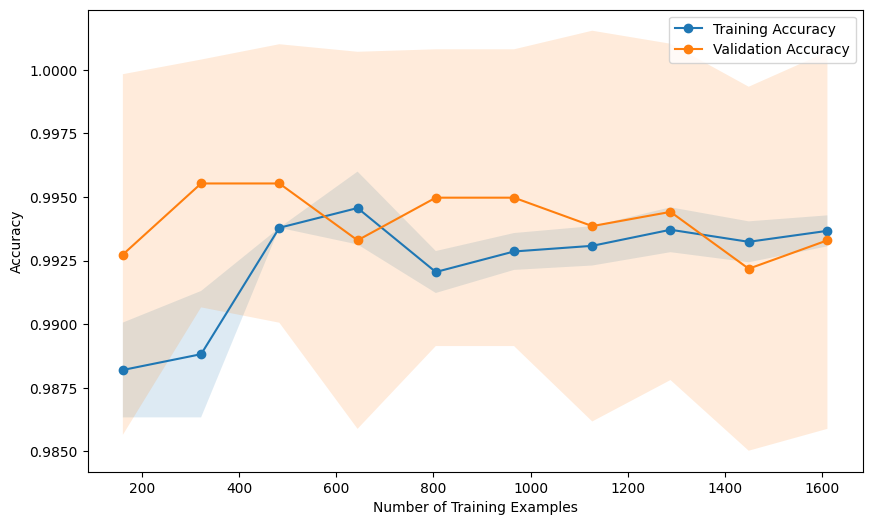

In [65]:
# Define and train model
knn_model = KNeighborsClassifier(n_neighbors = 25)
# Plot learning curves
print("Learning curves of KNN")
plot_learning_curves(knn_model,train_X,train_y)

In [66]:
# Define and train model
knn_model = KNeighborsClassifier(n_neighbors = 25)
knn_model.fit(train_X,train_y)
# Predict testing labels using model
predicted = knn_model.predict(test_X)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       146
           1       1.00      1.00      1.00       137
           2       1.00      0.99      1.00       165

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



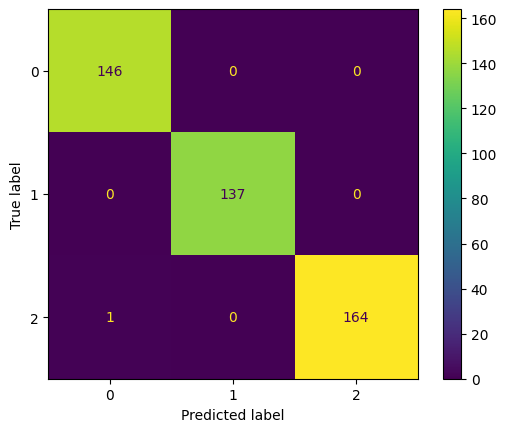

In [67]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **Logistic Regression**

Learning curves of LR


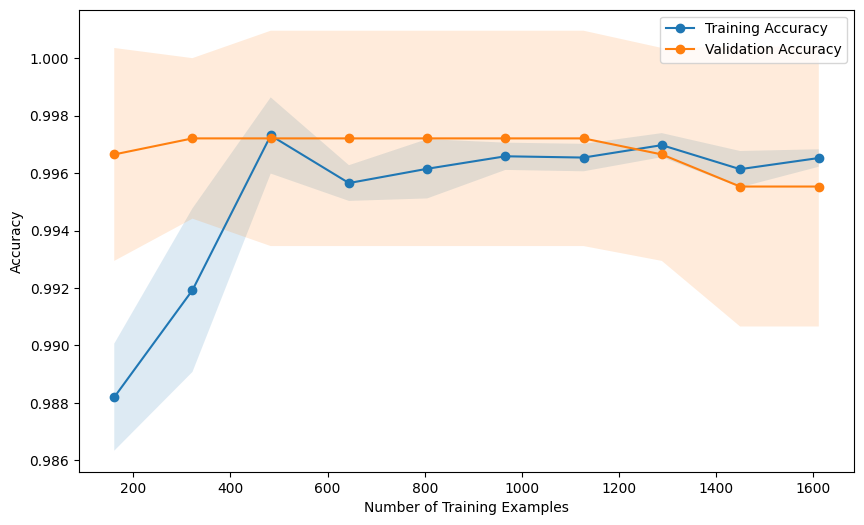

In [68]:
# Define and train model
log_model = LogisticRegression(random_state=42)
# Plot learning curves
print("Learning curves of LR")
plot_learning_curves(log_model,train_X,train_y)

In [69]:
# Define and train model
log_model = LogisticRegression(random_state=42)
log_model.fit(train_X,train_y)
# Predict testing labels using model
predicted = log_model.predict(test_X)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       165

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



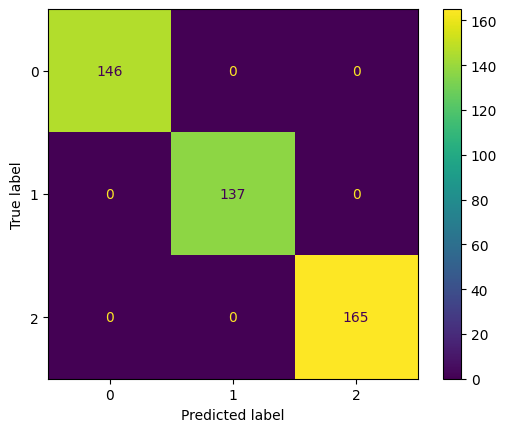

In [70]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **Naive Bayes**

Learning curves of NB


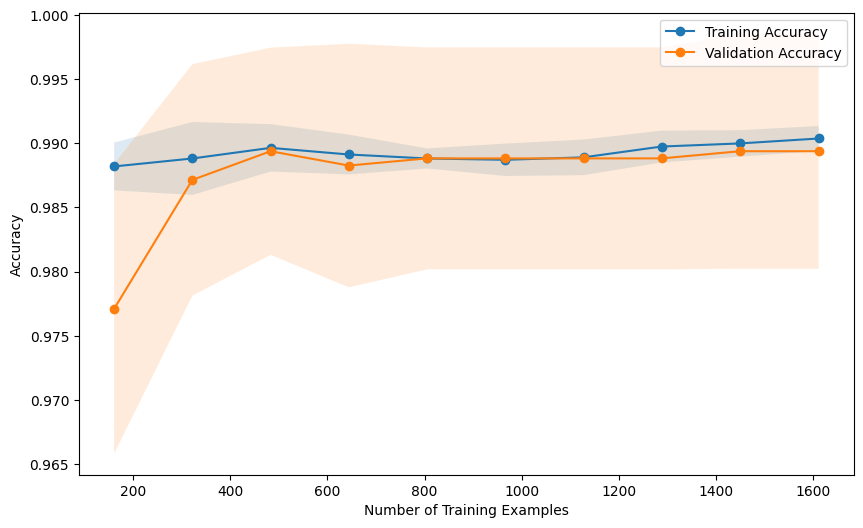

In [71]:
# Define and train model
naive_model = GaussianNB()
# Plot learning curves
print("Learning curves of NB")
plot_learning_curves(naive_model,train_X,train_y)

In [72]:
# Define and train model
naive_model = GaussianNB()
naive_model.fit(train_X,train_y)
# Predict testing labels using model
predicted = naive_model.predict(test_X)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       146
           1       1.00      0.99      1.00       137
           2       1.00      0.98      0.99       165

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



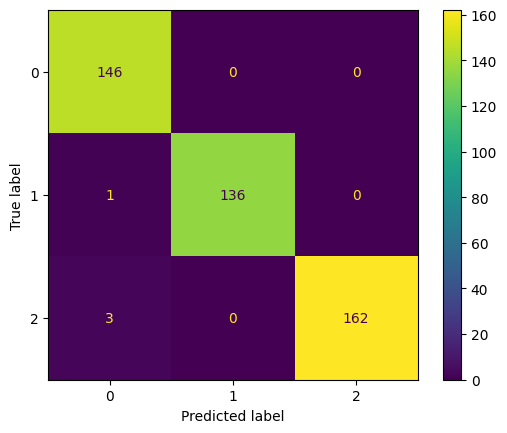

In [73]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **SVM**

Learning curves of SVM


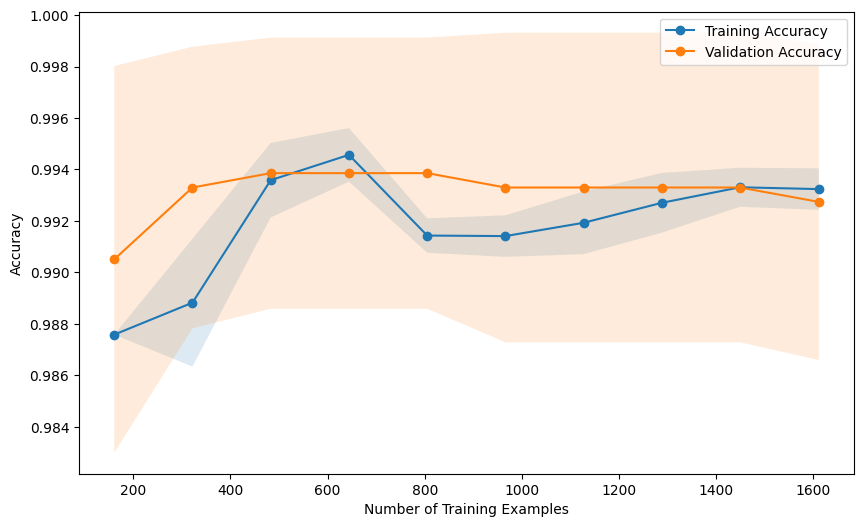

In [74]:
# Define and train model
svm_model =  SVC(kernel = "linear",random_state=42)
# Plot learning curves
print("Learning curves of SVM")
plot_learning_curves(svm_model,train_X,train_y)

In [75]:
# Define and train model
svm_model =  SVC(kernel = "linear",random_state=42)
svm_model.fit(train_X,train_y)
# Predict testing labels using model
predicted = svm_model.predict(test_X)

In [76]:
svm_model.coef_

array([[ 0.22001911, -3.08715375,  2.86916219],
       [-4.2286096 , -0.52308087,  4.75190778],
       [-2.58842029,  2.48267448,  0.10595333]])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       146
           1       0.99      1.00      1.00       137
           2       1.00      0.99      1.00       165

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



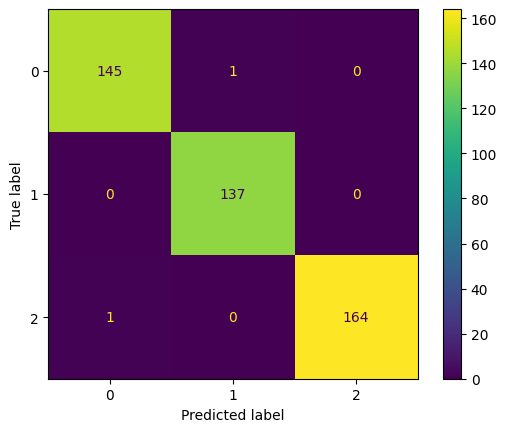

In [77]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **Decision Tree**

Learning curves of DT


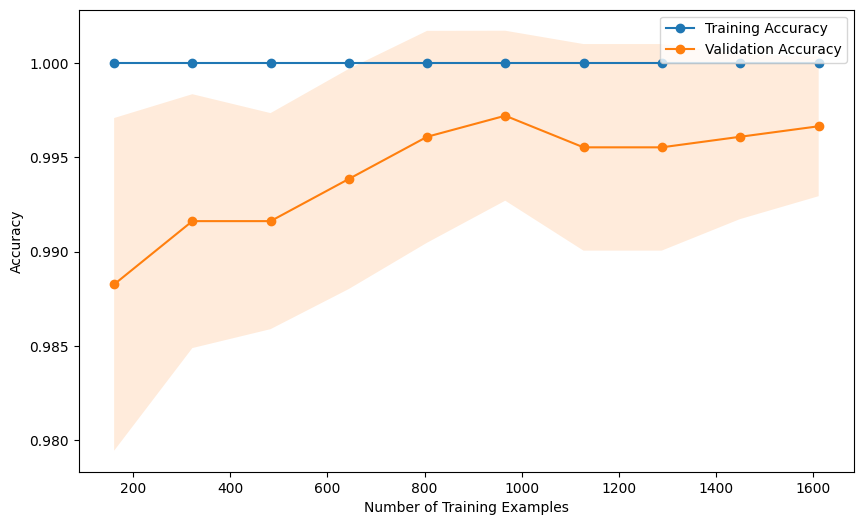

In [78]:
# Define and train model
tree_model = DecisionTreeClassifier(random_state=42)
# Plot learning curves
print("Learning curves of DT")
plot_learning_curves(tree_model,train_X,train_y)

In [79]:
# Define and train model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(train_X,train_y)
# Predict testing labels with model
predicted = tree_model.predict(test_X)

In [80]:
tree_model.feature_importances_

array([0.47987041, 0.01263813, 0.50749146])

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       146
           1       0.99      1.00      1.00       137
           2       0.99      0.99      0.99       165

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



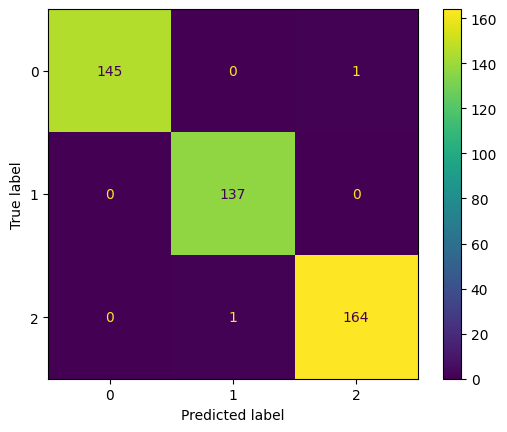

In [81]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **Random Forest**


Learning curves of RF


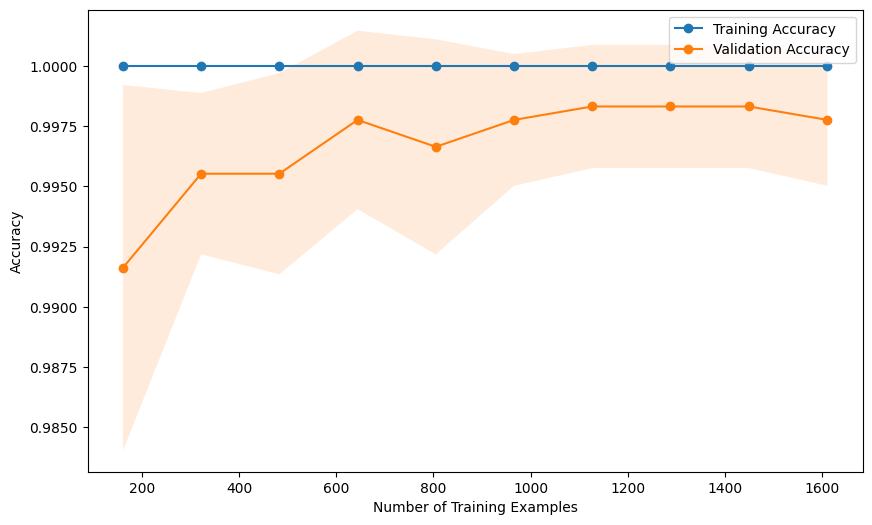

In [82]:
# Define and train model
forest_model = RandomForestClassifier(n_estimators = 100,random_state=42)
# Plot learning curves
print("Learning curves of RF")
plot_learning_curves(forest_model,train_X,train_y)

In [83]:
# Define and train model
forest_model = RandomForestClassifier(n_estimators = 100,random_state=42)
forest_model.fit(train_X,train_y)
# Predict testing labels using model
predicted = forest_model.predict(test_X)

In [84]:
forest_model.feature_importances_

array([0.34388496, 0.34196578, 0.31414927])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       0.99      1.00      1.00       137
           2       1.00      0.99      1.00       165

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



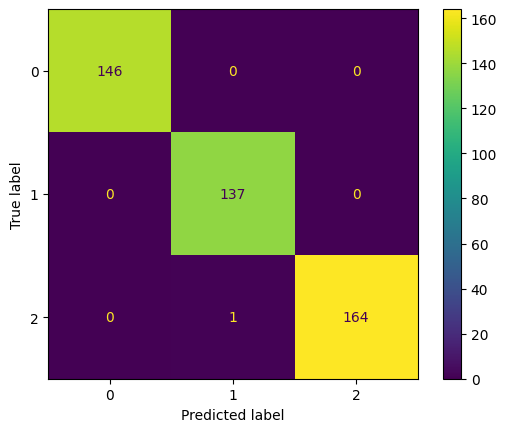

In [85]:
# Evaluate model
conf_mat, class_report = evaluation(test_y,predicted)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
print(class_report)

## **Champion Classification Model**

Based on the classification reports, RF is the champion model since it achieved 100% testing accuracy, 100% testing F1 score, 100% testing precision, and 100% testing recall. Based on the learning curves, the training and testing curves were both increasing and plateau at about 100%. This indicates that RF was able to effectively capture the problem complexity and learn from the data. Also, the gap between the training and testing curves is small indicating good generalization.

# **Pickle Champion Model**

In [107]:
champ_model = RandomForestClassifier(n_estimators = 100, random_state=42)
champ_model.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [109]:
with open("champ_model.pickle", "wb") as file:
  pickle.dump(champ_model,file,protocol = pickle.HIGHEST_PROTOCOL)